In [119]:
import numpy as np
import scipy as sp
import os
import glob
import matplotlib.pyplot as plt
import imageio

from sklearn import manifold
from sklearn import decomposition

# Minimal First Version

The results below are from a simulation run with the following settings:

- 1000 epochs
- 1 culture
- 4 agents
- 2 nearest neighbours for interactions
- 10 artefacts selected for each epoch and each agent

The current model generates new artefacts based on the mean of the 10 artefacts selected for each agent. Then each agent checks which other agents are nearby by taking each new artefact and map them into the cultures conceptual space.

It uses a Recurrent Variational Autoencoders for the conceptual spaces.
There is no external observer and only one culture. Because of that 

There isn't much interesting going just yet. Using the current seed (the first octave), the area covered by the conceptual space does seem to level out at some point. This appears perfectly natural as the agents use seed and representation that covers everything.

Considering/Todo:

- add a second culture and the external observer
- let the seed only covers the midi range (24-35), but the character table should be larger (21-108). Make the representation wider.
- add blank spaces? long sequences?
- larger populations
- non-uniform selection of artefacts in the field. Newer works should have more weight?
- add novelty evaluation
- add intentionality
- add evolution mechanics?
- deeper RVAE's with a lower latent dimension

In [120]:
data_path = "../data/output/output_2020-06-21T13-25-32.npy"

x = np.load(data_path, allow_pickle=True)

artefacts = np.array([a[5] for a in x])
agent_ids = np.array([a[1] for a in x])

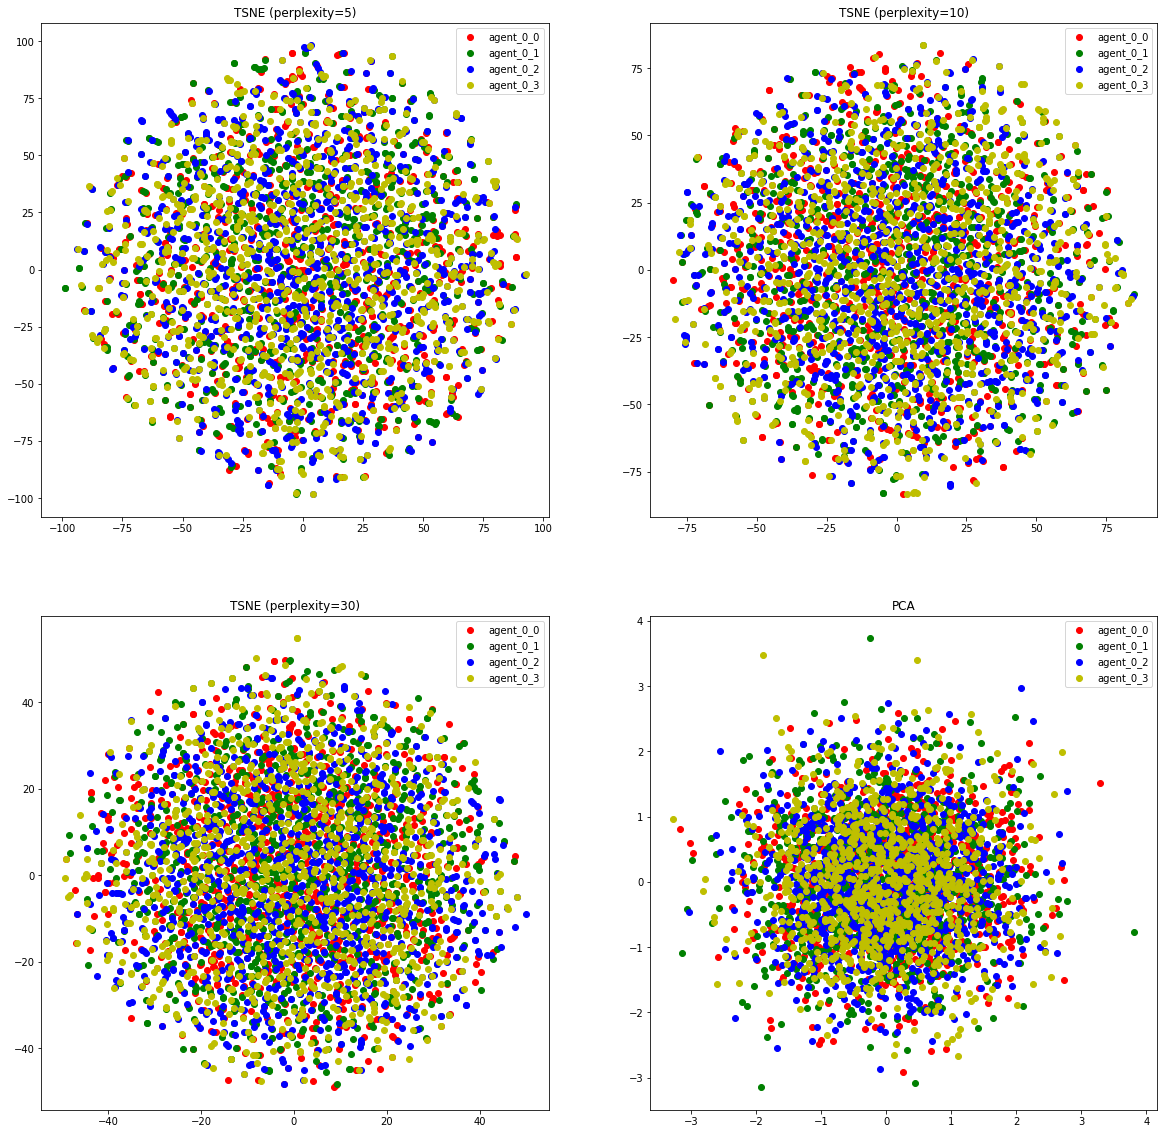

Number of artefacts: 4000


In [121]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

labels = ["agent_0_0", "agent_0_1", "agent_0_2", "agent_0_3"]
colors = ["r", "g", "b", "y"]

perplexities = [5, 10, 30]

for i, ax in enumerate(axs.flatten()):
    if i < 3:
        tsne = manifold.TSNE(n_components=2, random_state=1, perplexity=perplexities[i])
        embedded = tsne.fit_transform(artefacts)
        ax.set_title(f"TSNE (perplexity={perplexities[i]})")
    else:
        pca = decomposition.PCA(n_components=2)
        embedded = pca.fit_transform(artefacts)
        ax.set_title("PCA")

    for i, label in enumerate(labels):
        x, y = embedded[i::4, 0], embedded[i::4, 1]
        ax.scatter(x, y, c=colors[i % 4], label=label)
    
    ax.legend()

plt.show()
print(f"Number of artefacts: {len(artefacts)}")

No clusters are forming, which is not strange at all since all these agents belong to the same culture. Under the current circumstances, a minimal model with randomly selecting artefacts, there is no clique formation.

I tried various perplexities, and finally PCA for comparison. It seems that all agents end up with a more or less similar conceptual space.

In [132]:
# tsne = manifold.TSNE(n_components=2, perplexity=5, random_state=1)
# embedded = tsne.fit_transform(artefacts)

# frames = [embedded[:i] for i in range(1, len(embedded) + 2)]

# for i, frame in enumerate(frames):
#     fig, ax = plt.subplots(1,1)
    
#     for j, label in enumerate(labels):
#         x, y = frame[j::4, 0], frame[j::4, 1]
#         ax.scatter(x, y, c=colors[j % 4], label=label)

#     ax.set_ylim(-200, 200)
#     ax.set_xlim(-200, 200)
#     plt.savefig(f"tsne_animation/frame_{i:04d}.png")
#     plt.close(fig)

# anim_file = 'tsne.gif'

# with imageio.get_writer(anim_file, mode='I') as writer:
#     filenames = glob.glob('tsne_animation/frame_*.png')
#     filenames = sorted(filenames)
#     last = -1
    
#     for i, filename in enumerate(filenames):
#         frame = 2 * (i ** .5)
#         if round(frame) > round(last):
#             last = frame
#         else:
#             continue
        
#         image = imageio.imread(filename)
#         writer.append_data(image)

#     image = imageio.imread(filename)
#     writer.append_data(image)

# print('Gif Generated!')

In [122]:
volumes = []

pca = decomposition.PCA(n_components=3)
pca_embedded = pca.fit_transform(artefacts)

hull = sp.spatial.ConvexHull(pca_embedded[:4], incremental=True)
volumes.append(hull.volume)

for i in range(4, len(artefacts)):
    hull.add_points([pca_embedded[i]])
    volumes.append(hull.volume)

hull.close()

Ideally, I want to calculate the volume of the points in 32d-space. But unfortunately, this can't be done for the larger datasets. I used PCA because of its speed, and when using TSNE, the distance between the points means nothing.

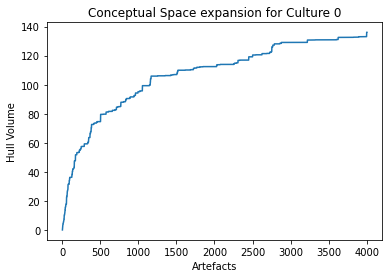

In [136]:
plt.plot(range(4, len(volumes) + 4), volumes)
plt.gca().set_title("Conceptual Space for Culture 0")
plt.gca().set_ylabel('Hull Volume')
plt.gca().set_xlabel('Artefacts')
plt.show()

The graph below is to check if the model deteriorates after training on a few samples every epoch.

It shows the losses on the seed, after every 10th epoch (to reduce the computational cost). Strangely, the loss still increases even though it just trains on a few new samples. You would expect the model to overfit on those samples.

Now the validation is the same as the seed. In the future, I should generate a validation seed, and then generate baselines when seeding the initial models.

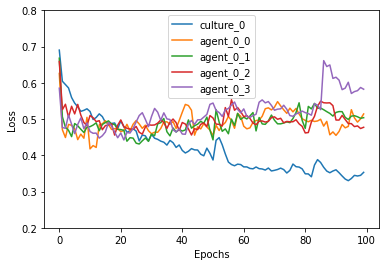

In [134]:
data_eval_path = "../data/output/output_2020-06-21T13-25-32_validation.npy"
evaluations = np.load(data_eval_path, allow_pickle=True)

labels = ["culture_0", "agent_0_0", "agent_0_1", "agent_0_2","agent_0_3"]

fig, ax = plt.subplots(1, 1)
for i, evaluation in enumerate(evaluations):
    ax.plot(range(len(evaluation)), evaluation, label=labels[i])

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.set_ylim(.2, .8)
plt.legend()
plt.show()